In [1]:
import pandas as pd

# Load the uploaded dataset
file_path = "/content/Messy_Customer_Journey_Dataset.csv"
df = pd.read_csv(file_path)

# Display the first few rows to understand the structure
df.head()


,user_id,session_id,event,timestamp,source,device
0,5839.0,S05839,Visit,2023-08-26 13:17:27,Email,Desktop
1,7612.0,S07612,Visit,2023-10-26 16:43:56,Email,Mobile
2,18221.0,S18221,AddToCart,2023-11-10 08:36:14,Paid,NaN
3,12274.0,S12274,ProductView,2023-12-16 00:27:37,NaN,Desktop
4,505.0,S00505,SignUp,2023-01-25 06:24:27,NaN,Mobile


 Funnel Summary:
                    Stage  Sessions  Dropoff Rate (%)
event                                               
Visit              Visit     19986         24.752327
ProductView  ProductView     15039        -24.004256
SignUp            SignUp     18649         51.841922
AddToCart      AddToCart      8981         63.923839
Purchase        Purchase      3240               NaN


<ipython-input-4-a711e9b84991>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  device_heatmap = device_dropoff.groupby(['device', 'event']).size().unstack().fillna(0)


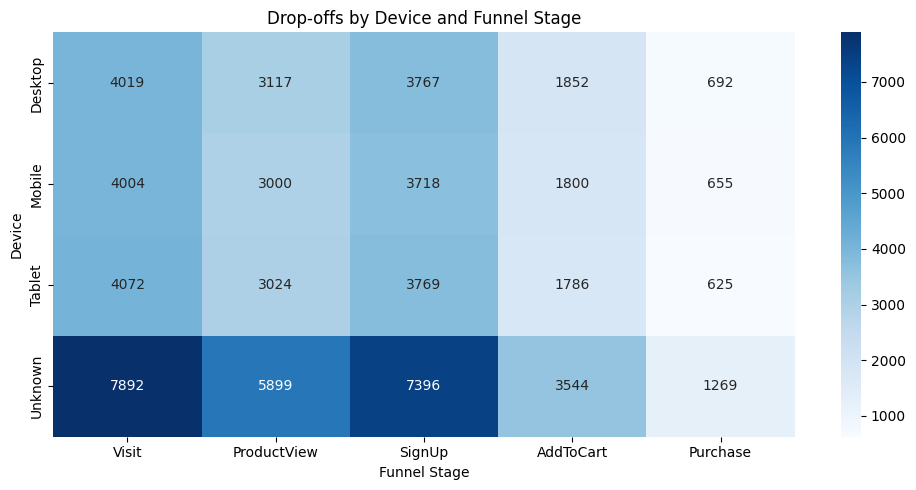

<ipython-input-4-a711e9b84991>:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  source_heatmap = source_dropoff.groupby(['source', 'event']).size().unstack().fillna(0)


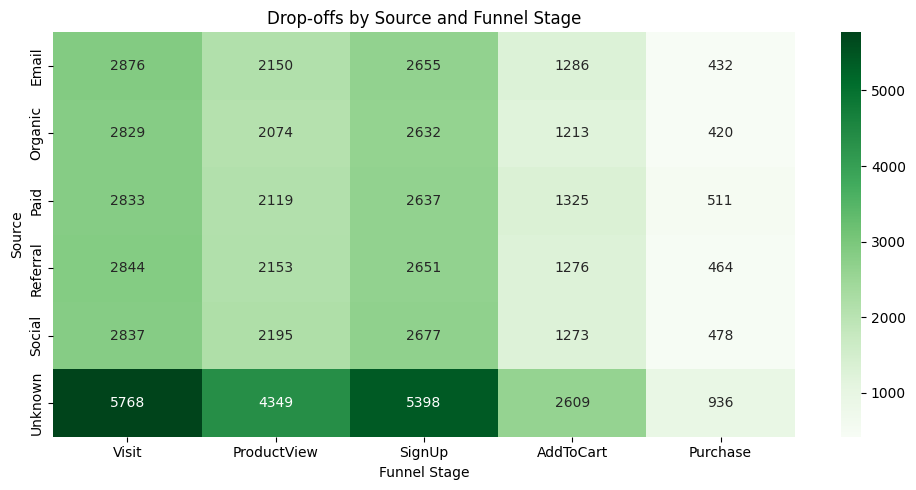


 Average Time Between Funnel Stages (minutes):
 event
Visit          17708.517577
ProductView    31216.768175
SignUp         36870.204603
AddToCart      12820.034837
Purchase         937.154676
Name: duration_to_next_event, dtype: float64


<ipython-input-4-a711e9b84991>:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_durations = duration_df.groupby('event')['duration_to_next_event'].mean()


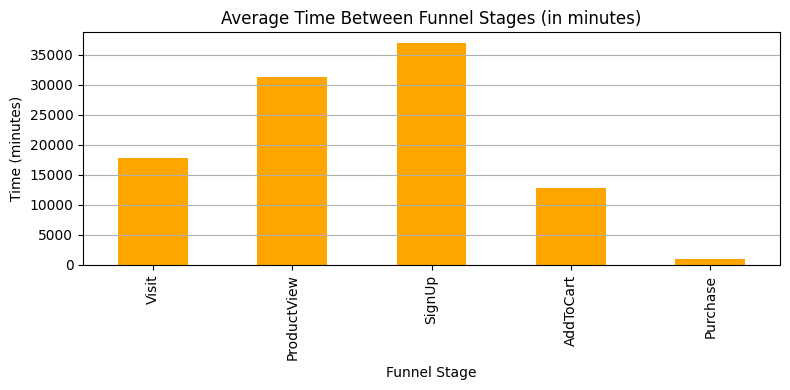

In [4]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
df = pd.read_csv("Messy_Customer_Journey_Dataset.csv")
df.columns = df.columns.str.strip().str.lower()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['event'] = df['event'].str.strip()
df['source'] = df['source'].fillna("Unknown")
df['device'] = df['device'].fillna("Unknown")

# Funnel Events
funnel_order = ['Visit', 'ProductView', 'SignUp', 'AddToCart', 'Purchase']
df['event'] = pd.Categorical(df['event'], categories=funnel_order, ordered=True)

# Sort & Deduplicate
funnel_df = df.sort_values(by=['session_id', 'timestamp']).drop_duplicates(subset=['session_id', 'event'])

# Funnel Counts
funnel_counts = funnel_df.groupby('event', observed=True)['session_id'].nunique().reindex(funnel_order)
funnel_summary = pd.DataFrame({
    'Stage': funnel_order,
    'Sessions': funnel_counts.values,
    'Dropoff Rate (%)': (1 - funnel_counts.shift(-1) / funnel_counts) * 100
})
print(" Funnel Summary:\n", funnel_summary)

# Event Transitions
funnel_df['next_event'] = funnel_df.groupby('session_id')['event'].shift(-1)

# Device Dropoff Heatmap
device_dropoff = funnel_df[funnel_df['event'] != funnel_df['next_event']]
device_heatmap = device_dropoff.groupby(['device', 'event']).size().unstack().fillna(0)

plt.figure(figsize=(10, 5))
sns.heatmap(device_heatmap, cmap='Blues', annot=True, fmt=".0f")
plt.title("Drop-offs by Device and Funnel Stage")
plt.ylabel("Device")
plt.xlabel("Funnel Stage")
plt.tight_layout()
plt.show()

# Source Dropoff Heatmap
source_dropoff = funnel_df[funnel_df['event'] != funnel_df['next_event']]
source_heatmap = source_dropoff.groupby(['source', 'event']).size().unstack().fillna(0)

plt.figure(figsize=(10, 5))
sns.heatmap(source_heatmap, cmap='Greens', annot=True, fmt=".0f")
plt.title("Drop-offs by Source and Funnel Stage")
plt.ylabel("Source")
plt.xlabel("Funnel Stage")
plt.tight_layout()
plt.show()

# Duration Analysis
funnel_df['next_timestamp'] = funnel_df.groupby('session_id')['timestamp'].shift(-1)
funnel_df['duration_to_next_event'] = (funnel_df['next_timestamp'] - funnel_df['timestamp']).dt.total_seconds() / 60
duration_df = funnel_df.dropna(subset=['duration_to_next_event'])

avg_durations = duration_df.groupby('event')['duration_to_next_event'].mean()
print("\n Average Time Between Funnel Stages (minutes):\n", avg_durations)

# Duration Plot
plt.figure(figsize=(8, 4))
avg_durations.plot(kind='bar', color='orange')
plt.title("Average Time Between Funnel Stages (in minutes)")
plt.ylabel("Time (minutes)")
plt.xlabel("Funnel Stage")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
